In [1]:
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Tomita_Grammars import *
from Extraction import extract

from transformers import Trainer, TrainingArguments
from transformers import BertConfig, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import trange

import torch
import torch.nn as nn
import transformers
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import BertConfig, BertForSequenceClassification, DistilBertForSequenceClassification, DistilBertConfig, AdamW


In [9]:
alphabet = "01"
distil_model_config = DistilBertConfig(
    vocab_size=len(alphabet),   
    hidden_dim=32,
    dim=32,
    n_heads=4
)
train_arg = TrainingArguments(
    output_dir='./results',          # 输出目录
    num_train_epochs=200,              # 训练轮数
    per_device_train_batch_size=1,   # 每个设备的训练批次大小
    per_device_eval_batch_size=1,    # 每个设备的测试批次大小
    warmup_steps=500,                # 预热步数
    weight_decay=0.01,               # 权重衰减
    logging_dir='./logs',            # 日志目录
    logging_steps=10,               # 日志步数
    learning_rate=5e-4,             # 学习率
)
class NumberDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        string, label = self.data[idx]
        # 将字符串转换为整数列表
        binary_list = [int(bit) for bit in string]
        # 返回一个字典，模仿transformers期望的输入格式
        return {
            "input_ids": torch.tensor(binary_list, dtype=torch.long), # 注意调整dtype
            "labels": torch.tensor(label, dtype=torch.long)
        }
class HiddenStateDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y
distil_model = DistilBertForSequenceClassification(distil_model_config)
target = mod_n(3)
class RNNClassifier(nn.Module):
    def __init__(self, rnn):
        super(RNNClassifier, self).__init__()
        self.rnn = rnn
        self.fc_1 = nn.Linear(32, 64)
        self.fc_2 = nn.Linear(64, 2)
    def forward(self, x):
        _, x = self.rnn(x)
        x = self.fc_1(x)
        x = nn.functional.relu(x)
        x = self.fc_2(x)
        return x
    
class TransformerNetwork:
    def __init__(self, model, train_arg, alphabet, rnn_arg, target):
        """
        :param model: Transformer model
        :param train_arg: Training arguments for Transformer model
        :param alphabet: list of characters in the alphabet from 0 to 9. E.g. "01"
        :param rnn_arg: Arguments for RNN model, a dictionary
        :param target: Target language, a function
        """
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.char_embedding = None
        self.rnn_train_data = None
        self.rnn_test_data = None
        self.target = target
        self.alphabet = alphabet
        self.model = model.to(self.device)
        self.train_arg = train_arg
        self.rnn_arg = rnn_arg
        rnn = nn.RNN(input_size=distil_model_config.dim, hidden_size=distil_model_config.dim, batch_first=True)
        self.rnn = RNNClassifier(rnn).to(self.device)
        self.data = list(make_train_set_for_target(self.target, alphabet).items())[1:]
        self.train_data, self.test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        self.train_dataset = NumberDataset(self.train_data)
        self.test_dataset = NumberDataset(self.test_data)
        self.train_loader = DataLoader(self.train_dataset, batch_size=1, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        
    def classify_word(self, word):
        """
        :param word: a string of 0s and 1s
        :return: 1 if the word is in the target language, 0 otherwise
        """
        if len(word) == 0:
            return self.classify_state(torch.tensor([0 for _ in range(model_config.hidden_size)], dtype=torch.float32)).item()
            #return self.target('')
        input = torch.tensor([int(bit) for bit in word], dtype=torch.long).to(self.device)#.unsqueeze(0)
        input = [self.char_embedding[str(char.item())].squeeze() for char in input]
        input = torch.stack(input, dim=0).view(-1, 32)
        with torch.no_grad():
            return self.rnn(input).argmax().item()
            #return self.model(input).logits.argmax().item()
    def model_classify_word(self, word):
        """
        :param word: a string of 0s and 1s
        :return: 1 if the word is in the target language, 0 otherwise
        """
        if len(word) == 0:
            return self.target('')
        input = torch.tensor([int(bit) for bit in word], dtype=torch.long).to(self.device).unsqueeze(0)
        with torch.no_grad():
            return self.model(input).logits.argmax().item()
    def extract_embedding(self):
        """
        Step 1. enumerate how the characters embedded in the model by getting the hidden states of the model when
        processing each character in the alphabet
        Step 2. average the hidden states of each character to get the embedding of the character
        :return: a dictionary, char -> tensor
        """
        char_embedding = {}
        for char in self.alphabet:
            input = torch.tensor([int(char)], dtype=torch.long).unsqueeze(0).to(self.device)
            with torch.no_grad():
                hidden_states = self.model(input, output_hidden_states=True).hidden_states
            char_embedding[char] = hidden_states[-1].squeeze()
        self.char_embedding = char_embedding
    def train_transformer(self):
        """
        Train the transformer model
        """
        self.trainer = Trainer(
            model=self.model,
            args=self.train_arg,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
        )
        self.trainer.train()
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        for x in test_loader:
            input = x['input_ids'].to(self.device)
            label = x['labels']
            correct += self.model(input).logits.argmax() == label[0]
            total += 1
        print("Correct:" ,correct.item())
        print("Total:", total)
        self.trainer.evaluate()
    def train_rnn(self):
        """
        Train the RNN model, embedding is given by extract_embedding
        """
        # Make the training data
        self.rnn_train_data = []
        with torch.no_grad():
            for x in self.train_loader:
                input = x['input_ids'].to(self.device).squeeze(0)
                label = self.model(input.unsqueeze(0)).logits.argmax()
                input = [self.char_embedding[str(char.item())].squeeze() for char in input]
                input = torch.stack(input, dim=0).view(-1, 32)
                self.rnn_train_data.append((input, label))
        self.rnn_train_data, self.rnn_test_data = train_test_split(self.rnn_train_data, test_size=0.2, random_state=42)
        rnn_train_dataset = HiddenStateDataset(self.rnn_train_data)
        rnn_test_dataset = HiddenStateDataset(self.rnn_test_data)
        rnn_train_loader = DataLoader(rnn_train_dataset, batch_size=1, shuffle=True)
        rnn_test_loader = DataLoader(rnn_test_dataset, batch_size=1, shuffle=False)
        # Train the self.rnn model
        self.rnn = self.rnn.to(self.device)
        optimizer = AdamW(self.rnn.parameters(), lr=1e-3)
        for epoch in trange(100):
            for x in rnn_train_loader:
                input, label = x
                output = self.rnn(input)
                output = output.squeeze(0)
                loss = nn.CrossEntropyLoss()(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        # Test the self.rnn model
        self.rnn.eval()
        correct = 0
        total = 0
        for x in rnn_test_loader:
            input, label = x
            output = self.rnn(input)
            correct += output.argmax() == label
            total += 1
        print("Correct:" ,correct.item())
        print("Total:", total)
    def classify_state(self,state):
        output = self.rnn.fc_1(state.to(self.device))
        output = nn.functional.relu(output)
        output = self.rnn.fc_2(output)
        # return the label
        return output.argmax()
    def get_first_RState(self):
        state = [0 for _ in range(model_config.hidden_size)]
        #print("0",state, self.classify_state(torch.tensor(state, dtype=torch.float32)))
        return state, self.target('') #self.classify_state(torch.tensor(state, dtype=torch.float32)).item()
    def get_next_RState(self, state, char):
        input = self.char_embedding[char]
        input = input.unsqueeze(0).unsqueeze(0)
        input = input.to(self.device)
        state = torch.tensor(state, dtype=torch.float32).view(1, 1, 32)
        state = state.to(self.device)
        output, next_state = self.rnn.rnn(input, state)
        print("1",next_state.squeeze().tolist(), self.classify_state(next_state.squeeze()))
        return next_state.squeeze().tolist(), self.classify_state(next_state.squeeze()).item()

In [10]:
transformer = TransformerNetwork(distil_model, train_arg, alphabet, distil_model_config, target)
transformer.train_transformer()
transformer.model.eval()

made train set of size: 3425 , of which positive examples: 1675


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss


Correct: 346
Total: 685


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(2, 32, padding_idx=0)
      (position_embeddings): Embedding(512, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=32, out_features=32, bias=True)
            (k_lin): Linear(in_features=32, out_features=32, bias=True)
            (v_lin): Linear(in_features=32, out_features=32, bias=True)
            (out_lin): Linear(in_features=32, out_features=32, bias=True)
          )
          (sa_layer_norm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

In [2]:
alphabet = "01"
model_config = BertConfig(
    vocab_size=len(alphabet),  # 因为输入是二进制，所以词汇表大小设置为2
    hidden_size=32,  # 模型的隐藏层大小
    num_hidden_layers=2,  # 隐藏层数量
    num_attention_heads=2,  # 注意力头的数量
    intermediate_size=64,  # 前馈网络的大小
    num_labels=2,  # 输出标签的数量
)
train_arg = TrainingArguments(
    output_dir='./results',          # 输出目录
    num_train_epochs=200,              # 训练轮数
    per_device_train_batch_size=1,   # 每个设备的训练批次大小
    per_device_eval_batch_size=1,    # 每个设备的测试批次大小
    warmup_steps=500,                # 预热步数
    weight_decay=0.01,               # 权重衰减
    logging_dir='./logs',            # 日志目录
    logging_steps=10,               # 日志步数
    learning_rate=5e-4,             # 学习率
)
class NumberDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        string, label = self.data[idx]
        # 将字符串转换为整数列表
        binary_list = [int(bit) for bit in string]
        # 返回一个字典，模仿transformers期望的输入格式
        return {
            "input_ids": torch.tensor(binary_list, dtype=torch.long), # 注意调整dtype
            "labels": torch.tensor(label, dtype=torch.long)
        }
class HiddenStateDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y
model = BertForSequenceClassification(model_config)
target = tomita_1
class RNNClassifier(nn.Module):
    def __init__(self, rnn):
        super(RNNClassifier, self).__init__()
        self.rnn = rnn
        self.fc_1 = nn.Linear(32, 64)
        self.fc_2 = nn.Linear(64, 2)
    def forward(self, x):
        _, x = self.rnn(x)
        x = self.fc_1(x)
        x = nn.functional.relu(x)
        x = self.fc_2(x)
        return x
    
class TransformerNetwork:
    def __init__(self, model, train_arg, alphabet, rnn_arg, target):
        """
        :param model: Transformer model
        :param train_arg: Training arguments for Transformer model
        :param alphabet: list of characters in the alphabet from 0 to 9. E.g. "01"
        :param rnn_arg: Arguments for RNN model, a dictionary
        :param target: Target language, a function
        """
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.char_embedding = None
        self.rnn_train_data = None
        self.rnn_test_data = None
        self.target = target
        self.alphabet = alphabet
        self.model = model.to(self.device)
        self.train_arg = train_arg
        self.rnn_arg = rnn_arg
        rnn = nn.RNN(input_size=model_config.hidden_size, hidden_size=model_config.hidden_size, batch_first=True)
        self.rnn = RNNClassifier(rnn).to(self.device)
        self.data = list(make_train_set_for_target(self.target, alphabet).items())[1:]
        self.train_data, self.test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        self.train_dataset = NumberDataset(self.train_data)
        self.test_dataset = NumberDataset(self.test_data)
        self.train_loader = DataLoader(self.train_dataset, batch_size=1, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        
    def classify_word(self, word):
        """
        :param word: a string of 0s and 1s
        :return: 1 if the word is in the target language, 0 otherwise
        """
        if len(word) == 0:
            return self.classify_state(torch.tensor([0 for _ in range(model_config.hidden_size)], dtype=torch.float32)).item()
            #return self.target('')
        input = torch.tensor([int(bit) for bit in word], dtype=torch.long).to(self.device)#.unsqueeze(0)
        input = [self.char_embedding[str(char.item())].squeeze() for char in input]
        input = torch.stack(input, dim=0).view(-1, 32)
        with torch.no_grad():
            return self.rnn(input).argmax().item()
            #return self.model(input).logits.argmax().item()
    def model_classify_word(self, word):
        """
        :param word: a string of 0s and 1s
        :return: 1 if the word is in the target language, 0 otherwise
        """
        if len(word) == 0:
            return self.target('')
        input = torch.tensor([int(bit) for bit in word], dtype=torch.long).to(self.device).unsqueeze(0)
        with torch.no_grad():
            return self.model(input).logits.argmax().item()
    def extract_embedding(self):
        """
        Step 1. enumerate how the characters embedded in the model by getting the hidden states of the model when
        processing each character in the alphabet
        Step 2. average the hidden states of each character to get the embedding of the character
        :return: a dictionary, char -> tensor
        """
        char_embedding = {}
        for char in self.alphabet:
            input = torch.tensor([int(char)], dtype=torch.long).unsqueeze(0).to(self.device)
            with torch.no_grad():
                hidden_states = self.model(input, output_hidden_states=True).hidden_states
            char_embedding[char] = hidden_states[-1].squeeze()
        self.char_embedding = char_embedding
    def train_transformer(self):
        """
        Train the transformer model
        """
        self.trainer = Trainer(
            model=self.model,
            args=self.train_arg,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
        )
        self.trainer.train()
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        for x in test_loader:
            input = x['input_ids'].to(self.device)
            label = x['labels']
            correct += self.model(input).logits.argmax() == label[0]
            total += 1
        print("Correct:" ,correct.item())
        print("Total:", total)
        self.trainer.evaluate()
    def train_rnn(self):
        """
        Train the RNN model, embedding is given by extract_embedding
        """
        # Make the training data
        self.rnn_train_data = []
        with torch.no_grad():
            for x in self.train_loader:
                input = x['input_ids'].to(self.device).squeeze(0)
                label = self.model(input.unsqueeze(0)).logits.argmax()
                input = [self.char_embedding[str(char.item())].squeeze() for char in input]
                input = torch.stack(input, dim=0).view(-1, 32)
                self.rnn_train_data.append((input, label))
        self.rnn_train_data, self.rnn_test_data = train_test_split(self.rnn_train_data, test_size=0.2, random_state=42)
        rnn_train_dataset = HiddenStateDataset(self.rnn_train_data)
        rnn_test_dataset = HiddenStateDataset(self.rnn_test_data)
        rnn_train_loader = DataLoader(rnn_train_dataset, batch_size=1, shuffle=True)
        rnn_test_loader = DataLoader(rnn_test_dataset, batch_size=1, shuffle=False)
        # Train the self.rnn model
        self.rnn = self.rnn.to(self.device)
        optimizer = AdamW(self.rnn.parameters(), lr=1e-3)
        for epoch in trange(100):
            for x in rnn_train_loader:
                input, label = x
                output = self.rnn(input)
                output = output.squeeze(0)
                loss = nn.CrossEntropyLoss()(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        # Test the self.rnn model
        self.rnn.eval()
        correct = 0
        total = 0
        for x in rnn_test_loader:
            input, label = x
            output = self.rnn(input)
            correct += output.argmax() == label
            total += 1
        print("Correct:" ,correct.item())
        print("Total:", total)
    def classify_state(self,state):
        output = self.rnn.fc_1(state.to(self.device))
        output = nn.functional.relu(output)
        output = self.rnn.fc_2(output)
        # return the label
        return output.argmax()
    def get_first_RState(self):
        state = [0 for _ in range(model_config.hidden_size)]
        #print("0",state, self.classify_state(torch.tensor(state, dtype=torch.float32)))
        return state, self.target('') #self.classify_state(torch.tensor(state, dtype=torch.float32)).item()
    def get_next_RState(self, state, char):
        input = self.char_embedding[char]
        input = input.unsqueeze(0).unsqueeze(0)
        input = input.to(self.device)
        state = torch.tensor(state, dtype=torch.float32).view(1, 1, 32)
        state = state.to(self.device)
        output, next_state = self.rnn.rnn(input, state)
        print("1",next_state.squeeze().tolist(), self.classify_state(next_state.squeeze()))
        return next_state.squeeze().tolist(), self.classify_state(next_state.squeeze()).item()

In [ ]:
transformer = TransformerNetwork(model, train_arg, alphabet, model_config, target)
transformer.train_transformer()
transformer.model.eval()

In [4]:
transformer.extract_embedding()
transformer.rnn.train()
transformer.train_rnn()

C:\Work Space\AI Security\Transformer\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 100/100 [05:49<00:00,  3.50s/it]


Correct: 532
Total: 532


In [5]:
data = make_train_set_for_target(target,alphabet)
all_words = sorted(list(data.keys()),key=lambda x:-len(x))
pos = next((w for w in all_words if transformer.classify_word(w)==True),None)
neg = next((w for w in all_words if transformer.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]
print(starting_examples)


made train set of size: 3323 , of which positive examples: 1607
['011111000000011101100110011000', '000011010001001001010000100001']


provided counterexamples are: ['011111000000011101100110011000', '011101110010111100111000010000', '100000010100011010001011000100', '011111001010101101011110100000', '101110100010011001010010001000', '111000111010000011011101001100', '100000100110011110010101001000', '100100010010000110000001001000', '011001001010101000101001000000', '011110001110101010100011000100', '100101100001100110111101001000', '000000101111110101110110010100', '000011101010010100010100001000', '010100010000110001100100010000', '001101110000001100101101111100', '100111010010111110001110010100', '000010001011111100010010000100', '111000111101011001110001100100', '100110000110100000010010101000', '101101100001001010101001101100', '000001001101101001001100000000', '100010110101010000001100010100', '011111110110100101100001011000', '001011110101001011011101100100', '100110010001101111011111011000', '001010001000011111110001000000', '001010000110001011100100111000', '000111000000000010100100000000', '1010000001000000

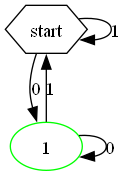

storing provided counterexample of length 30
returning counterexample of length 30:		100101101011110010110010111110, this counterexample is rejected by the given RNN.
equivalence checking took: 0.09217530000023544
obs table refinement took 0.089
guided starting equivalence query for DFA of size 3


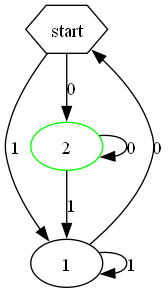

1 [0.4573080837726593, -0.6970844268798828, -0.7892659306526184, -0.34305426478385925, -0.31559979915618896, 0.9343383312225342, 0.9236454963684082, 0.6615490913391113, -0.9564033150672913, -0.21141444146633148, -0.7301228642463684, 0.8721484541893005, -0.7359718680381775, 0.6329201459884644, 0.1318632960319519, -0.6887253522872925, 0.9678776264190674, -0.968342661857605, 0.7348240613937378, 0.8011299967765808, -0.15336008369922638, -0.21976114809513092, 0.941632091999054, 0.02399611845612526, 0.7521588802337646, 0.48287659883499146, 0.9513711333274841, -0.9562042951583862, -0.9503310918807983, 0.09840098023414612, -0.6418120861053467, -0.03993935137987137] tensor(1, device='cuda:0')
1 [-0.8158584833145142, -0.4819616675376892, -0.584536075592041, 0.9792313575744629, 0.38743317127227783, -0.8881865739822388, -0.951097309589386, -0.9395242929458618, 0.9517898559570312, 0.8615648150444031, 0.9064855575561523, 0.2989753782749176, -0.7977182269096375, -0.9408045411109924, -0.32296285033226

In [6]:
transformer.rnn.eval()
dfa = extract(transformer,time_limit = 50,initial_split_depth = 10,starting_examples=starting_examples)

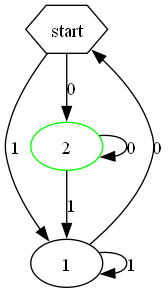

testing on train set, i.e. test set is train set
test set size: 3323
of which positive: 1607 (48.35%)
model score against target on test set: 3323 (100.0%)
rnn score against target on test set: 3322 (99.96%)
extracted dfa score against rnn on test set: 3323 (100.0%)
extracted dfa score against target: 3322 (99.96%)
extracted dfa score against model's results: 3322 (99.96%)


In [7]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw

test_set = data
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if transformer.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if transformer.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")
dfa_target_model = len([w for w in test_set if dfa.classify_word(w)==transformer.classify_word(w)])
print("extracted dfa score against target on model's test set:",dfa_target_model,"("+percent(dfa_target/n)+")")
